In [ ]:
!pip install requests beautifulsoup4 pandas spacy
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
pip install flask pandas


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from flask import Flask, request, jsonify
import spacy
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# SEC 10-K URLs
filings = {
    "Microsoft": "https://www.sec.gov/ix?doc=/Archives/edgar/data/0000789019/000095017024087843/msft-20240630.htm",
    "Tesla": "https://www.sec.gov/ix?doc=/Archives/edgar/data/0001318605/000162828025003063/tsla-20241231.htm",
    "Apple": "https://www.sec.gov/Archives/edgar/data/320193/000032019324000123/aapl-20240928.htm"
}

In [4]:
# Financial sections & keywords
financial_sections = {
    "Income Statement": {
        "Total Revenue": ["Total Revenue", "Net Sales", "Sales"],
        "COGS": ["Cost of Goods Sold", "Cost of Revenue"],
        "Operating Expenses": ["Operating Expenses"],
        "Net Income": ["Net Income", "Net Earnings"]
    },
    "Balance Sheet": {
        "Current Assets": ["Current Assets"],
        "Long-Term Assets": ["Long-Term Assets", "Non-Current Assets"],
        "Current Liabilities": ["Current Liabilities"],
        "Long-Term Liabilities": ["Long-Term Liabilities", "Non-Current Liabilities"],
        "Total Shareholders’ Equity": ["Total Shareholders’ Equity", "Stockholders' Equity"]
    },
    "Cash Flow Statement": {
        "Cash from Operating Activities": ["Net Cash Provided by Operating Activities",],
        "Cash from Investing Activities": ["Net Cash Used in Investing Activities"],
        "Cash from Financing Activities": ["Net Cash Used in Financing Activities"]
    }
}

In [8]:
def fetch_financial_data(company, url):
    """Extracts financial data from a company's 10-K filing."""
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"❌ Failed to fetch data for {company}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # Extract tables containing financial data
    tables = soup.find_all("table")

    extracted_data = {}

    for section, metrics in financial_sections.items():
        extracted_data[section] = {}

        for metric, synonyms in metrics.items():
            for table in tables:
                rows = table.find_all("tr")

                for row in rows:
                    cells = row.find_all("td")
                    if len(cells) >= 4:  # Ensure at least 3 years of data exist
                        for synonym in synonyms:
                            if synonym.lower() in cells[0].text.lower():
                                # Extract values for the last 3 years
                                values = [cell.text.strip() for cell in cells[1:4]]
                                extracted_data[section][metric] = values
                                break

    return extracted_data

In [9]:
# Extract data for each company
for company, url in filings.items():
    print(f"📊 Extracting data for {company}...")
    financials = fetch_financial_data(company, url)

    if financials:
        print(f"✅ Data for {company} (Last 3 Years):")
        for section, metrics in financials.items():
            print(f"\n🔹 {section}:")
            for metric, values in metrics.items():
                print(f"  {metric}: {values}")
    else:
        print(f"❌ No financial data found for {company}")

    print("-" * 50)

📊 Extracting data for Microsoft...
❌ Failed to fetch data for Microsoft
❌ No financial data found for Microsoft
--------------------------------------------------
📊 Extracting data for Tesla...
❌ Failed to fetch data for Tesla
❌ No financial data found for Tesla
--------------------------------------------------
📊 Extracting data for Apple...
❌ Failed to fetch data for Apple
❌ No financial data found for Apple
--------------------------------------------------


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/BCG_CHATBOT/10 K data.xlsx")

In [ ]:
df

,Year,Company,Total Revenue,Net Income,Total Assets,Total Liability,Cash flow from operating activities
0,2022,Microsoft,198270,72738,NaN,NaN,89035
1,2023,Microsoft,211915,72361,411976.0,205753.0,87582
2,2024,Microsoft,245122,88136,512163.0,243686.0,118548
3,2022,Tesla,81462,12587,NaN,NaN,14724
4,2023,Tesla,96773,14974,106618.0,43009.0,13256
5,2024,Tesla,97690,7153,122070.0,48390.0,14923
6,2022,Apple,391035,99803,NaN,NaN,122151
7,2023,Apple,383285,96995,352583.0,290437.0,110543
8,2024,Apple,394328,93736,364980.0,308030.0,118254


In [ ]:
# Sort data for accurate year-over-year comparison
df = df.sort_values(by=["Company", "Year"])

# List of financial metrics to calculate YoY change
metrics = ["Total Revenue", "Net Income", "Total Assets", "Total Liability", "Cash flow from operating activities"]

# Calculate percentage change for each metric
for metric in metrics:
    df[f"{metric} YoY Change (%)"] = df.groupby("Company")[metric].pct_change() * 100

# Display updated DataFrame
print(df)

   Year    Company  Total Revenue  Net Income  Total Assets  Total Liability  \
6  2022      Apple         391035       99803           NaN              NaN   
7  2023      Apple         383285       96995      352583.0         290437.0   
8  2024      Apple         394328       93736      364980.0         308030.0   
0  2022  Microsoft         198270       72738           NaN              NaN   
1  2023  Microsoft         211915       72361      411976.0         205753.0   
2  2024  Microsoft         245122       88136      512163.0         243686.0   
3  2022      Tesla          81462       12587           NaN              NaN   
4  2023      Tesla          96773       14974      106618.0          43009.0   
5  2024      Tesla          97690        7153      122070.0          48390.0   

   Cash flow from operating activities  Total Revenue YoY Change (%)  \
6                               122151                           NaN   
7                               110543                 

<ipython-input-5-8802efc5ecd9>:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{metric} YoY Change (%)"] = df.groupby("Company")[metric].pct_change() * 100
<ipython-input-5-8802efc5ecd9>:9: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f"{metric} YoY Change (%)"] = df.groupby("Company")[metric].pct_change() * 100


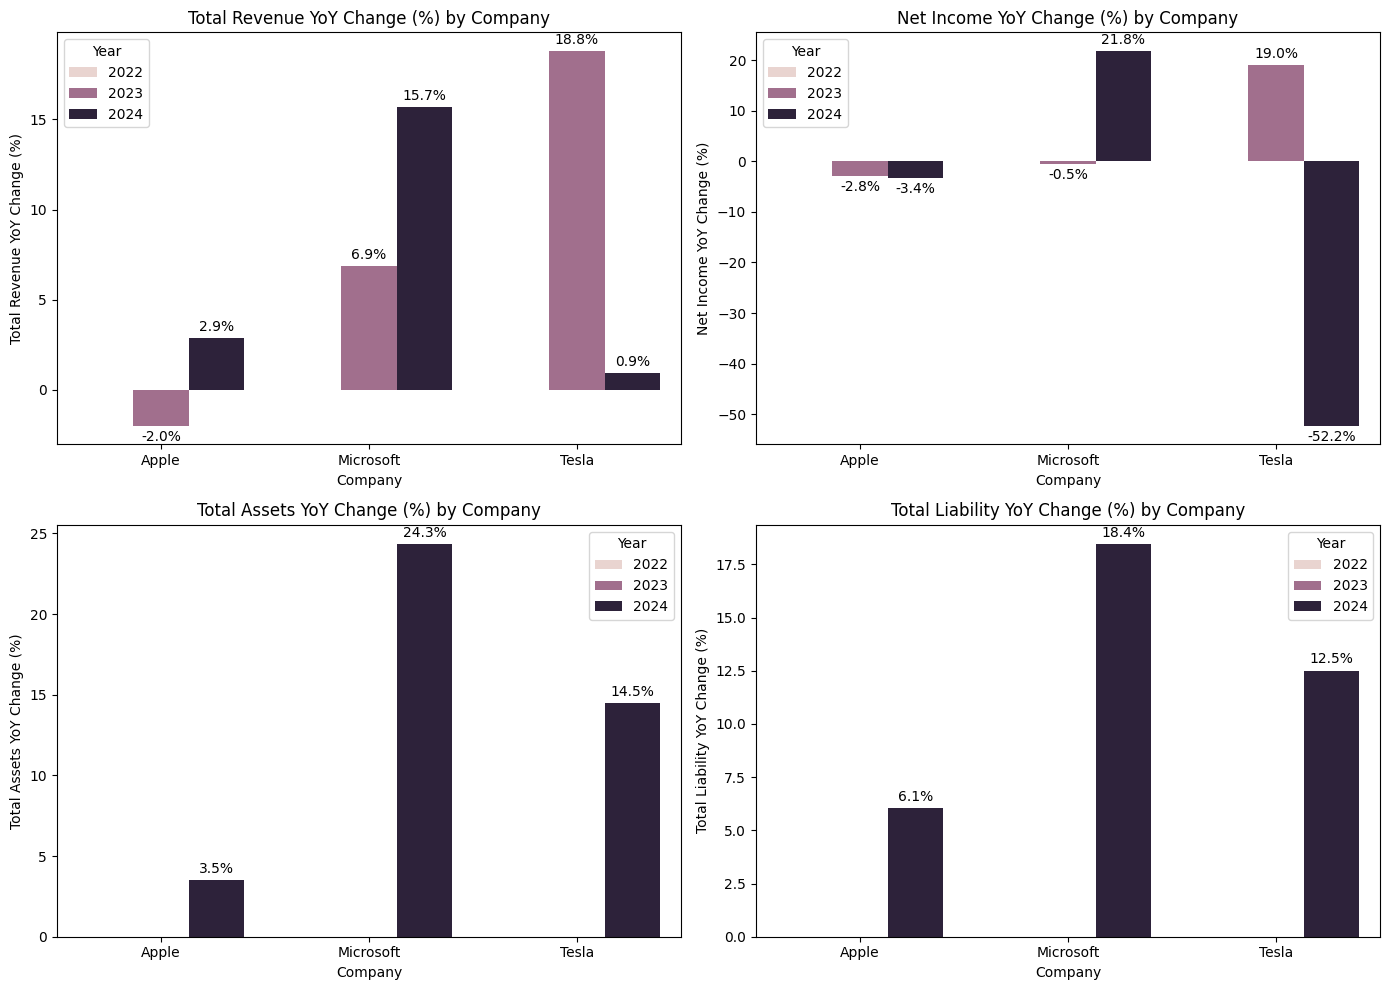

In [ ]:
# YoY Change Metrics (Assuming they are already computed)
yoy_metrics = [
    "Total Revenue YoY Change (%)",
    "Net Income YoY Change (%)",
    "Total Assets YoY Change (%)",
    "Total Liability YoY Change (%)",
    "Cash flow from operating activities YoY Change (%)"
]

#create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(yoy_metrics[:-1]):  # Skip last metric for now
    ax = axes[idx // 2, idx % 2]
    bars = sns.barplot(data=df, x="Company", y=metric, hue="Year", ax=ax)

    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)  # Adjust format and padding as needed

    ax.set_title(f"{metric} by Company")

plt.tight_layout()
plt.show()


Upon evaluating the YoY % changes, the following observations were made:  
-Microsoft performed exceptionally well across all key performance indicators (KPIs); however, its liabilities also increased significantly. This could be due to higher investment in R&D, acquisitions, or increased debt financing to support expansion.

-Apple experienced growth in revenue and assets in 2024 but saw a 3.4% decline in net income and a 6% increase in liabilities. The decline in net income might be attributed to rising production costs, increased operational expenses, or lower profit margins on new product lines. The rise in liabilities could indicate higher borrowing for innovation, supply chain investments, or stock buybacks.  

-Tesla had the highest revenue growth in 2023 at 19%, but in 2024, this growth slowed drastically to just 1%. More concerning is the 52% drop in net income, which raises red flags. This decline could be due to higher production costs, supply chain disruptions, price cuts to maintain demand, or increased competition in the EV market. The increase in assets and liabilities suggests Tesla may have expanded production capacity or taken on more debt to fund new projects.


In [ ]:
summary_df = df.groupby("Company").agg({
    "Total Revenue": ["sum", "mean", "median", "max", "min"],
    "Net Income": ["sum", "mean", "median", "max", "min"],
    "Total Assets": ["sum", "mean"],
    "Total Liability": ["sum", "mean"],
    "Cash flow from operating activities": ["sum", "mean"]
}).applymap(lambda x: "{:,.2f}".format(x))

print(summary_df)



          Total Revenue                                                  \
                    sum        mean      median         max         min   
Company                                                                   
Apple      1,168,648.00  389,549.33  391,035.00  394,328.00  383,285.00   
Microsoft    655,307.00  218,435.67  211,915.00  245,122.00  198,270.00   
Tesla        275,925.00   91,975.00   96,773.00   97,690.00   81,462.00   

           Net Income                                              \
                  sum       mean     median        max        min   
Company                                                             
Apple      290,534.00  96,844.67  96,995.00  99,803.00  93,736.00   
Microsoft  233,235.00  77,745.00  72,738.00  88,136.00  72,361.00   
Tesla       34,714.00  11,571.33  12,587.00  14,974.00   7,153.00   

          Total Assets             Total Liability              \
                   sum        mean             sum        mean   
Co

<ipython-input-29-4ed07a63e328>:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [ ]:
df.groupby("Year").agg({
    "Total Revenue": "sum",
    "Net Income": "sum",
    "Total Assets": "mean",
    "Total Liability": "mean",
    "Cash flow from operating activities": "sum"
})


,Total Revenue,Net Income,Total Assets,Total Liability,Cash flow from operating activities
Year,,,,,
2022,670767,185128,NaN,NaN,225910
2023,691973,184330,290392.333333,179733.000000,211381
2024,737140,189025,333071.000000,200035.333333,251725


In [ ]:
df["Profit Margin (%)"] = (df["Net Income"] / df["Total Revenue"]) * 100
df.groupby("Company")["Profit Margin (%)"].mean()


,Profit Margin (%)
Company,
Apple,24.866696
Microsoft,35.596183
Tesla,12.748947


In [ ]:
df["Debt-to-Assets Ratio"] = df["Total Liability"] / df["Total Assets"]
df.groupby("Company")["Debt-to-Assets Ratio"].mean()

,Debt-to-Assets Ratio
Company,
Apple,0.833852
Microsoft,0.487614
Tesla,0.399903


In [ ]:
df["Operating Cash Flow Efficiency"] = df["Cash flow from operating activities"] / df["Total Revenue"]
df.groupby("Company")["Operating Cash Flow Efficiency"].mean()

,Operating Cash Flow Efficiency
Company,
Apple,0.300225
Microsoft,0.448659
Tesla,0.156829


In [ ]:

# Profitability Ratios
df["Profit Margin (%)"] = (df["Net Income"] / df["Total Revenue"]) * 100
df["ROA (%)"] = (df["Net Income"] / df["Total Assets"]) * 100
df["ROE (%)"] = (df["Net Income"] / (df["Total Assets"] - df["Total Liability"])) * 100

# Liquidity & Leverage Ratios
df["Current Ratio"] = df["Total Assets"] / df["Total Liability"]
df["Debt-to-Equity Ratio"] = df["Total Liability"] / (df["Total Assets"] - df["Total Liability"])

# Cash Flow Metrics
df["Operating Cash Flow to Net Income"] = df["Cash flow from operating activities"] / df["Net Income"]
df["Cash Flow to Revenue (%)"] = (df["Cash flow from operating activities"] / df["Total Revenue"]) * 100

# Display DataFrame with new metrics
df


,Year,Company,Total Revenue,Net Income,Total Assets,Total Liability,Cash flow from operating activities,Total Revenue YoY Change (%),Net Income YoY Change (%),Total Assets YoY Change (%),...,Revenue Growth (%),Net Income Growth (%),Asset Growth (%),ROA (%),ROE (%),Current Ratio,Debt-to-Equity Ratio,Operating Cash Flow to Net Income,Cash Flow to Revenue (%),Operating Cash Flow Ratio
6,2022,Apple,391035,99803,NaN,NaN,122151,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.223921,31.237869,NaN
7,2023,Apple,383285,96995,352583.0,290437.0,110543,-1.981920,-2.813543,NaN,...,-1.981920,-2.813543,NaN,27.509835,156.076015,1.213974,4.673462,1.139677,28.840941,0.380609
8,2024,Apple,394328,93736,364980.0,308030.0,118254,2.881146,-3.359967,3.516052,...,2.881146,-3.359967,3.516052,25.682503,164.593503,1.184885,5.408780,1.261564,29.988740,0.383904
0,2022,Microsoft,198270,72738,NaN,NaN,89035,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.224051,44.905936,NaN
1,2023,Microsoft,211915,72361,411976.0,205753.0,87582,6.882030,-0.518299,NaN,...,6.882030,-0.518299,NaN,17.564373,35.088715,2.002284,0.997721,1.210348,41.328835,0.425666
2,2024,Microsoft,245122,88136,512163.0,243686.0,118548,15.669962,21.800417,24.318650,...,15.669962,21.800417,24.318650,17.208584,32.828138,2.101733,0.907661,1.345058,48.362856,0.486479
3,2022,Tesla,81462,12587,NaN,NaN,14724,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.169778,18.074685,NaN
4,2023,Tesla,96773,14974,106618.0,43009.0,13256,18.795267,18.964010,NaN,...,18.795267,18.964010,NaN,14.044533,23.540694,2.478970,0.676146,0.885268,13.698036,0.308215
5,2024,Tesla,97690,7153,122070.0,48390.0,14923,0.947578,-52.230533,14.492862,...,0.947578,-52.230533,14.492862,5.859753,9.708198,2.522629,0.656759,2.086258,15.275873,0.308390


<ipython-input-24-84f40b5e8a3c>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Company", y="Current Ratio", ax=axes[2, 0], palette="viridis")
<ipython-input-24-84f40b5e8a3c>:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Company", y="Debt-to-Equity Ratio", ax=axes[2, 1], palette="magma")


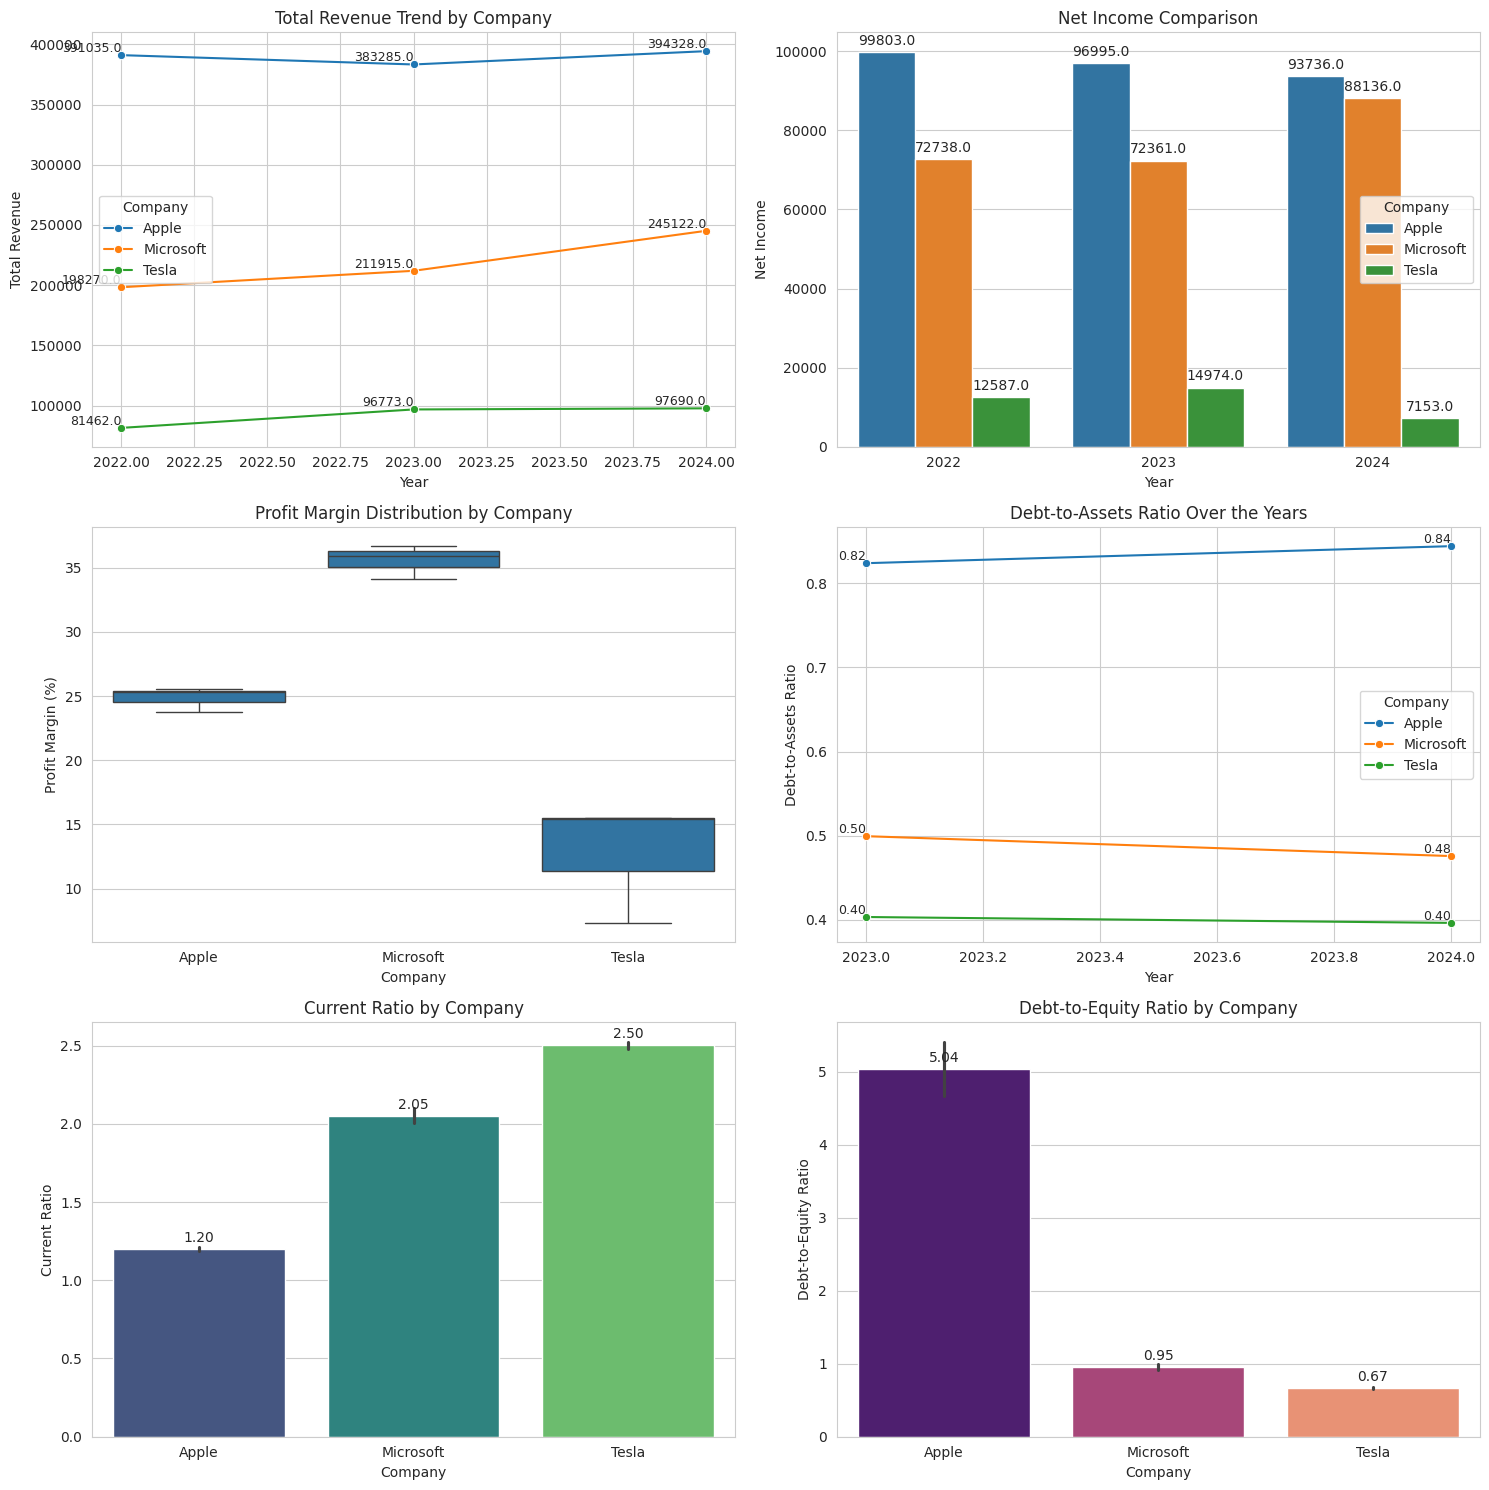

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))


sns.lineplot(data=df, x="Year", y="Total Revenue", hue="Company", marker="o", ax=axes[0, 0])
axes[0, 0].set_title("Total Revenue Trend by Company")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Total Revenue")
axes[0, 0].grid(True)


for line in axes[0, 0].lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        axes[0, 0].text(x, y, f"{y:.1f}", ha="right", va="bottom", fontsize=9)

sns.barplot(data=df, x="Year", y="Net Income", hue="Company", ax=axes[0, 1])
axes[0, 1].set_title("Net Income Comparison")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Net Income")

for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt="%.1f", padding=3)

sns.boxplot(data=df, x="Company", y="Profit Margin (%)", ax=axes[1, 0])
axes[1, 0].set_title("Profit Margin Distribution by Company")
axes[1, 0].set_xlabel("Company")
axes[1, 0].set_ylabel("Profit Margin (%)")


sns.lineplot(data=df, x="Year", y="Debt-to-Assets Ratio", hue="Company", marker="o", ax=axes[1, 1])
axes[1, 1].set_title("Debt-to-Assets Ratio Over the Years")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Debt-to-Assets Ratio")
axes[1, 1].grid(True)

for line in axes[1, 1].lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        axes[1, 1].text(x, y, f"{y:.2f}", ha="right", va="bottom", fontsize=9)

sns.barplot(data=df, x="Company", y="Current Ratio", ax=axes[2, 0], palette="viridis")
axes[2, 0].set_title("Current Ratio by Company")

for container in axes[2, 0].containers:
    axes[2, 0].bar_label(container, fmt="%.2f", padding=3)

sns.barplot(data=df, x="Company", y="Debt-to-Equity Ratio", ax=axes[2, 1], palette="magma")
axes[2, 1].set_title("Debt-to-Equity Ratio by Company")


for container in axes[2, 1].containers:
    axes[2, 1].bar_label(container, fmt="%.2f", padding=3)


plt.tight_layout()
plt.show()


In [ ]:
fig = px.bar(df, x="Company", y=["ROA (%)", "ROE (%)"],
             color="Year", barmode="group",
             title="ROA vs ROE by Company",
             facet_row="variable")

fig.update_layout(height=600)
fig.show()


In [ ]:

fig3 = px.imshow(df[["ROA (%)", "ROE (%)", "Profit Margin (%)", "Debt-to-Equity Ratio"]].corr(),
                 text_auto=True, title="Correlation Between Financial Metrics")

fig3.show()

Based on these financial ratios, we observe the following:  

- Profit Margin: Microsoft has the highest profit margin, followed by Apple and then Tesla. A higher profit margin indicates better cost efficiency and profitability. Microsoft’s strong margin suggests effective cost management and pricing strategies, while Tesla's lower margin may be due to high production costs or pricing pressures.  

- Debt-to-Assets Ratio: Microsoft and Tesla have a debt-to-assets ratio below 0.5, which is favorable as it indicates they rely less on debt for financing. In contrast, Apple’s ratio is 0.82, meaning a significant portion of its assets is financed through debt. While debt financing can help drive growth, a higher ratio increases financial risk, especially if interest rates rise or revenue declines.  

- Liquidity (Current Ratio): All three companies have current ratios above 1.0, indicating they have sufficient short-term assets to cover their short-term liabilities. A ratio above 1 is generally considered a sign of good financial health, as it means the company is unlikely to face immediate liquidity issues.  

- Return on Equity (ROE): This measures how effectively a company generates profit from shareholders' equity. Apple's ROE increased over the past two years, suggesting improved efficiency in using its equity to generate profits. However, both Microsoft and Tesla experienced declines, which could indicate lower profitability or increased equity without a proportional increase in net income.  

- **Return on Assets (ROA):** This ratio measures how efficiently a company uses its assets to generate profit. Microsoft’s ROA remained relatively stable, suggesting consistent asset efficiency. However, Tesla and Apple saw declines, which could mean lower profitability or higher asset investments that have not yet translated into increased earnings.  

- Operating Cash Flow to Net Income: A ratio greater than 1 suggests a company is generating strong cash flow relative to its net income, which is a positive sign. All three companies maintained a ratio above 1, but Tesla briefly dropped below this level in 2023. This could indicate lower cash flow from operations compared to reported earnings, possibly due to increased capital expenditures or working capital changes. However, Tesla rebounded in 2024, suggesting an improvement in cash flow generation.  

- Cash Flow to Revenue (%): This metric reflects how much of a company's revenue translates into cash flow. All three companies experienced a decline in 2023, which may indicate higher operating costs, lower sales efficiency, or increased reinvestment into the business. However, they all showed recovery in 2024, demonstrating improved cash management and financial stability.  

Overall, while Microsoft appears to have strong profitability and stable asset efficiency, Apple shows resilience with an increasing ROE but relies more on debt financing. Tesla, despite having the highest revenue growth at some points, has struggled with profitability and cash flow consistency but showed signs of recovery in 2024.

BUILDING THE CHATBOT

In [ ]:
app = Flask(__name__)

data = df

In [ ]:
df.columns = [col.lower() for col in df.columns]
columns = df.columns.tolist()
companies = df["company"].unique().tolist()  # List of company names
years = df["year"].unique().tolist()  # Available years

In [ ]:
# Load your NLP model (using spaCy)
nlp = spacy.load("en_core_web_sm")

In [ ]:
def process_query(query):
    """Preprocess query using NLP"""
    doc = nlp(query.lower())
    keywords = [token.lemma_ for token in doc if not token.is_stop]
    return " ".join(keywords)

def find_best_match(query):
    processed_query = process_query(query)
    best_match = difflib.get_close_matches(processed_query, columns, n=1, cutoff=0.5)
    return best_match[0] if best_match else None

def extract_filters(query):
    """Extract company name and year from user input"""
    company_match = next((c for c in companies if c.lower() in query.lower()), None)
    year_match = next((y for y in years if str(y) in query), None)
    return company_match, year_match


def financial_chatbot(query):
    best_match = find_best_match(query)
    company, year = extract_filters(query)

    if best_match:

        filtered_data = df
        if company:
            filtered_data = filtered_data[filtered_data["company"].str.lower() == company.lower()]
        if year:
            filtered_data = filtered_data[filtered_data["year"] == year]

        if not filtered_data.empty:
            result = filtered_data[[best_match, "company", "year"]]
            return result.to_string(index=False)
        else:
            return "No data found for the given filters."

    return "Sorry, I couldn't find relevant financial data."

while True:
    query = input("\nAsk a financial question (or type 'exit' to quit): ")
    if query.lower() == "exit":
        print("\nGoodbye! Have a great day! 😊")
        break
    print("\n" + financial_chatbot(query))



Ask a financial question (or type 'exit' to quit): what is the revenue

 total revenue   company  year
        391035     Apple  2022
        383285     Apple  2023
        394328     Apple  2024
        198270 Microsoft  2022
        211915 Microsoft  2023
        245122 Microsoft  2024
         81462     Tesla  2022
         96773     Tesla  2023
         97690     Tesla  2024

Ask a financial question (or type 'exit' to quit): what is roe for apple

   roe (%) company  year
       NaN   Apple  2022
156.076015   Apple  2023
164.593503   Apple  2024

Ask a financial question (or type 'exit' to quit): what is net income of tesla in 2023

 net income company  year
      14974   Tesla  2023

Ask a financial question (or type 'exit' to quit): exit

Goodbye! Have a great day! 😊


In [ ]:
!python chatbot.py

python3: can't open file '/content/chatbot.py': [Errno 2] No such file or directory
